In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, multiprocessing as mp
from numpy import random
import torch, cv2, time, random, os, threading, pickle

In [2]:
DTYPE = {
    'boolean': torch.bool, 'ui8': torch.uint8, 'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64, 
    'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64, 'f64Complex': torch.complex64, 'f128Complex': torch.complex128
}
DEVICE = {
    'auto': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), 
    'cpu': torch.device('cpu'), 
    'cuda0': torch.device('cuda:0')
}

DEVICE_CHOICE = 'auto'

In [24]:
class DNN(object):
    def __init__(self, layers=(10, 20, 10), aFunc=('cos', 'PRelu', 'PRelu', 'sin')):
        self.layerNum = len(layers)
        assert self.layerNum >= 1
        torch.manual_seed(0)
        self.backProp = {
            'PRelu': True,  # 如果False, 则 == Leaky Relu
            'Norm': [True] * self.layerNum
        }
        self.paramLimits = {
            'weights': (-100000, 100000), 
            'biases': (-100000, 100000), 
            'relu param': (-100, 100), 
            'BN gamma': (-1000, 1000), 
            'BN beta': (-1000, 1000), 
            'dW': (-1, 1), 
            'dB': (-10, 10), 
            'dReluP': (-10, 10), 
            'dGamma': (-10, 10), 
            'dBeta': (-10, 10)
        }
        self.layerShapes = layers
        self.aFuncChosen = aFunc
        self.defaultLr = 0.0001
        self.lr = {
            'weight': self.defaultLr * 250,
            'bias': self.defaultLr * 5000,
            'relu param': self.defaultLr * 10, 
            'BN gamma': self.defaultLr, 
            'BN beta': self.defaultLr
        }
        self.inputs = None
        self.targetY = None
        self.weights = [None] * self.layerNum
        self.biases = [None] * self.layerNum
        self.reluParam = [0.01] * self.layerNum
        self.layers = {
            'Z': [None] * self.layerNum, 
            'N': [None] * self.layerNum, 
            'A': [None] * self.layerNum
        }
        self.BN = {
            'epsilon': 1e-5, 
            'gamma': [1] * self.layerNum, 
            'beta': [0] * self.layerNum, 
            'cache': [None] * self.layerNum
        }
        self.activFunc = {
            'PRelu': lambda x, i: torch.max(x, x * self.reluParam[i]), 
            'sigmoid': lambda x: 1/(1+torch.exp(-x)), 
            'softmax': lambda x: torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x))), 
            'tanh': lambda x: torch.tanh(x), 
            'sin': lambda x: torch.sin(x), 
            'cos': lambda x: torch.cos(x), 
            'linear': lambda x: x
        }
        self.activFuncDer = {
            'PRelu': self._PReluDer,  
            'sigmoid': lambda x: self.activFunc['sigmoid'](x) * (1 - self.activFunc['sigmoid'](x)), 
            'softmax': lambda x, a: self.activFunc['softmax'](x) * (a - self.activFunc['softmax'](x)), 
            'tanh': lambda x: 1 - torch.tanh(x) ** 2, 
            'sin': lambda x: torch.cos(x), 
            'cos': lambda x: -torch.sin(x), 
            'linear': lambda x: 1
        }
        self.lossFunc = {
            'mse': lambda predictY, targetY: (targetY - predictY) ** 2, 
            'bce': lambda predictY, targetY: targetY * torch.log(predictY) + (1 - targetY) * torch.log(1 - predictY)
        }
        self.lossFuncDer = {
            'mse': lambda predictY, targetY: 2 * (targetY - predictY), 
            'bce': lambda predictY, targetY: Y / predictY + (targetY - 1) / (1 - predictY)
        }
    
    def _dA_dReluP(self, x, i):
        data = x.clone()
        data[data > 0] = 0
        data[data <= 0] = torch.mean(data[data <= 0])
        return data
    
    def _PReluDer(self, x, i): 
        data = x.clone()
        data[data > 0] = 1
        data[data <= 0] = self.reluParam[i]
        return data
    
    def setBackProp(self, **kwargs):
        '''
        Keys: PRelu, Norm
        Values: True, (True, False ..)
        '''
        for k, v in kwargs.items():
            try:
                self.backProp[k] = v
            except:
                continue
            
    def batchNorm(self, x, layerIter):
        mean = torch.mean(x)
        variance = torch.mean((x - mean) ** 2)
        # normalize
        fenzi = (x - mean) * 1.0
        fenmu = torch.sqrt(variance + self.BN['epsilon'])
        # * 1.0 是转换成float
        xNorm = fenzi / fenmu
        cache = {
            'BNmean': mean, 
            'BNvariance': variance, 
            'BNfenzi': fenzi, 
            'BNfenmu': fenmu
        }
        self.BN['cache'][layerIter] = cache
        return self.BN['gamma'][layerIter] * xNorm + self.BN['beta'][layerIter]
    
    def setToLimit(self, data, limits):
        x = data.clone()
        x[x<limits[0]] = limits[0]
        x[x>limits[1]] = limits[1]
        return x
    
    # 生成 w、b, 以x的形状是 m x 1
    def genParam(self, inputRow):
        column = inputRow
        for i, r in enumerate(self.layerShapes):
#             print('row: ', row, '\ncolumn: ', column)
            self.weights[i] = torch.ones(r, column, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.biases[i] = torch.zeros(r, 1, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            column = r

    # 前向传播函数
    def forward(self, x):
        inputs = x
#         print('inputs.shape: ', inputs.shape)
        for i in range(self.layerNum):
#             print(f'w[{i}].shape: ', self.weights[i].shape)
#             print(f'b[{i}].shape: ', self.biases[i].shape)
            layerNameFirst = 'N' if self.backProp['Norm'][i] else 'Z'
            self.layers['Z'][i] = self.weights[i] @ inputs + self.biases[i]
            self.layers['N'][i] = self.batchNorm(self.layers['Z'][i], i)
            if self.aFuncChosen[i] == 'PRelu':
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers[layerNameFirst][i], i)
            else:
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers[layerNameFirst][i])
            inputs = self.layers['A'][i]
#             print(f'layer[{i}].shape: ', self.layers['A'][i].shape)
    
    # 反向传播函数
    # input = x, Z = W @ input + b, N = batchNormalize(Z), Y_preditc = activateFunc(N), L = lossFunc(Y_predict)
    # 根据链式法则 dL / dW = (dL / dY_predict) * (dY_predict / dN) * (dN / dZ) * (dZ / dW)
    # dL / dY_predict = lossFunc_Der, dY_predict / dN = activateFunc_Der, dN/dZ = gamma/sqrt(variance+epsilon), dZ/dW = input
    # ==> dL / dW = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * input
    # 同理可证 dL / db = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * 1
    def backprop(self):
        '''
        尚未完成
        '''
            
        dW = [None] * self.layerNum
        dB = [None] * self.layerNum
        dReluP = [None] * self.layerNum
        dGamma = [None] * self.layerNum
        dBeta = [None] * self.layerNum
        dActivation = [None] * self.layerNum
        
        dL_Div_dYtrain = self.lossFuncDer['mse'](self.layers['A'][-1], self.targetY)
        
        for i in reversed(range(self.layerNum)):
#             print('i: ', i)
            layerNameFirst = 'N' if self.backProp['Norm'][i] else 'Z'
            if self.aFuncChosen[i] == 'PRelu':
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers[layerNameFirst][i], i)
            else:
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers[layerNameFirst][i])
#             print(f'weight[{i}] shape: {self.weights[i].shape} \nbias[{i}] shape: {self.biases[i].shape} \n')
            if i == self.layerNum - 1:
                dBeta[i] = dB[i] = dL_Div_dYtrain * dActivation[i]
                dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
                if self.backProp['Norm'][i]:
                    dB[i] *= self.BN['gamma'][i] / self.BN['cache'][i]['BNfenmu']
                if self.backProp['PRelu']:
                    dReluP[i] = torch.mean(dL_Div_dYtrain * self.layers[layerNameFirst][i])
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
            else:
                dB[i] = (torch.transpose(self.weights[i+1], 0, 1) @ dB[i+1]) * dActivation[i]
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                dBeta[i] = torch.transpose(self.weights[i+1], 0, 1) @ (dBeta[i+1] * (self.BN['gamma'][i+1] / self.BN['cache'][i+1]['BNfenmu']))
                dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
                if self.backProp['PRelu']:
                    dReluP[i] = torch.mean(torch.transpose(self.weights[i], 0, 1) @ dB[i] * self.layers[layerNameFirst][i-1])
                    
#             print(f'dReluP[{i}]: {dReluP[i]}')
            dB_Limited = self.setToLimit(dB[i], self.paramLimits['dB'])
            dW_Limited = self.setToLimit(dW[i], self.paramLimits['dW'])
        
            self.biases[i] += dB_Limited * self.lr['bias']
            self.weights[i] += dW_Limited * self.lr['weight']
            
#             self.biases[i] = self.setToLimit(self.biases[i], self.paramLimits['biases'])
#             self.weights[i] = self.setToLimit(self.weights[i], self.paramLimits['weights'])
            
            if self.aFuncChosen[i] == 'PRelu' and self.backProp['PRelu']:
                dReluP_Limited = self.setToLimit(dReluP[i], self.paramLimits['dReluP']).item()
                self.reluParam[i] += dReluP_Limited * self.lr['relu param']
#                 print('PRelu back proped')
            if self.backProp['Norm'][i]:
                dBeta_Limited = torch.mean(self.setToLimit(dBeta[i], self.paramLimits['dBeta'])).item()
                dGamma_Limited = torch.mean(self.setToLimit(dGamma[i], self.paramLimits['dGamma'])).item()
                self.BN['beta'][i] += dBeta_Limited * self.lr['BN gamma']
                self.BN['gamma'][i] += dGamma_Limited * self.lr['BN beta']
#                 print('BN back proped')
#             print(self.reluParam)
            
    def train(self, inputs, targetY, nanInvestigate=40, epoch = 1000):
        self.targetY = targetY
        self.inputs = inputs
        for e in range(epoch):
            self.forward(inputs)
            loss = torch.norm(self.layers['A'][-1] - self.targetY)
            print(e, f': loss = {loss}')
            if loss < 5.0 or e > int(epoch/2):
                for k,v in self.lr.items():
                    self.lr[k] /= 2
            if loss < 2.0 or e > int(epoch*0.9):
                for k,v in self.lr.items():
                    self.lr[k] /= 5
            if loss < 1.0 or torch.isnan(loss):
                return
#                 print(f'{i} Loss: ', torch.mean(self.lossFunc['mse'](self.layers['A'][-1], self.targetY)).item())
#                 print(epoch/100, ': \n', torch.transpose(self.layers['A'][-1], 0, 1))
            self.backprop()
            if e > nanInvestigate and nanInvestigate > 0:
                self.saveParams('d:\\nanInvest_'+str(e)+'.pt', True)
                
    def printShape(self):
        for i in range(self.layerNum):
            print(f'weight[{i}] shape: ', self.weights[i].shape)
            print(f'bias[{i}] shape: ', self.biases[i].shape)
            print(f'Relu Params[{i}]: ', self.reluParam[i])
            print(f'BN gamma[{i}]: ', self.BN['gamma'][i])
            print(f'BN beta[{i}]: ', self.BN['beta'][i])
#             print(f'Z layer shape: ', self.layers['Z'][i].shape)
#             print(f'N layer shape: ', self.layers['N'][i].shape)
#             print(f'A layer shape: ', self.layers['A'][i].shape)
    
    def saveParams(self, PATH, layers=False, reluParam=False, BN=False):
        params = {
            'weight': self.weights, 
            'bias': self.biases
        }
        if layers:
            params['layers'] = self.layers
        if reluParam:
            params['reluParam'] = self.reluParam
        if BN:
            params['BN'] = self.BN
        torch.save(params, PATH)
        
    def readParams(self, PATH, layers=False, reluParam=False, BN=False):
        params = torch.load(PATH)
        self.weights = params['weight']
        self.biases = params['bias']
        if layers:
            self.layers = params['layers']
        if reluParam:
            self.reluParam = params['reluParam']
        if BN:
            self.BN = params['BN']
    
    # 预测
    def predict(self, x):
        self.forward(x)
        predictY = self.layers['A'][-1]
        print('output: ', predictY.squeeze())
        return predictY

In [26]:
if __name__ == '__main__':
    layers = (50, 50, 50, 40000)
    aFuncs = ('PRelu', 'cos', 'sin', 'PRelu')
    normLayer = (True, True, True, False)
    epoch = 30
    nn1 = DNN(layers, aFuncs)
    nn1.setBackProp(PRelu=True, Norm=normLayer)
    # 生成权重和偏移
    nn1.genParam(40000)
    testInput = [None] * 20
    targetY = [None] * 20
    for i in range(20):
        # 生成训练数据
        # 所有input全部变型成 m x 1 的形状
        testInput[i] = torch.sin(torch.randn((200, 200), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE]).view(-1, 1))
        # 生成目标输出
        targetY[i] = ((i+1)*torch.sin(testInput[i]**(i+1))) + ((i+1)*torch.cos((i+1)*testInput[i]-i)) * torch.tanh(testInput[i]+1)
    # 训练
    for k in range(3):
        for i in range(20):      
            nn1.train(testInput[i], targetY[i], nanInvestigate=0, epoch=epoch)
        print('k: ', k)
        nn1.printShape()
    # 预测
    estimateY = nn1.predict(testInput[19])
    
    plt.scatter(testInput[0].cpu().numpy().flatten(), targetY[0].cpu().numpy().flatten())
    plt.scatter(testInput[0].cpu().numpy().flatten(), estimateY.cpu().numpy().flatten())
    plt.show()
    nn1.printShape()

0 : loss = 190.03899605849998
1 : loss = 66.87714211527951
2 : loss = 66.7957636900456
3 : loss = 66.82044455752948
4 : loss = 66.75295269744228
5 : loss = 66.77860008221977
6 : loss = 66.70776912667266
7 : loss = 66.73435151418718
8 : loss = 66.66006518786412
9 : loss = 66.68755122449812
10 : loss = 66.60968768859195
11 : loss = 66.63804380232668
12 : loss = 66.5564754623983
13 : loss = 66.58566569498103
14 : loss = 66.50025895648976
15 : loss = 66.53024477459473
16 : loss = 66.44085983091603
17 : loss = 65.90048898468653
18 : loss = 65.91034756068929
19 : loss = 65.8842656708442
20 : loss = 65.88181485153825
21 : loss = 65.88003623879337
22 : loss = 65.87949317878481
23 : loss = 65.87914032755346
24 : loss = 65.87899197895833
25 : loss = 65.87891830430645
26 : loss = 65.87888152050833
27 : loss = 65.87886313123083
28 : loss = 65.87885393695298
29 : loss = 65.87885301753657
0 : loss = 275.3758587128453
1 : loss = 275.3755353461734
2 : loss = 275.37521198071585
3 : loss = 275.374888616

5 : loss = 1363.504463541584
6 : loss = 1363.504463541584
7 : loss = 1363.504463541584
8 : loss = 1363.504463541584
9 : loss = 1363.504463541584
10 : loss = 1363.504463541584
11 : loss = 1363.504463541584
12 : loss = 1363.504463541584
13 : loss = 1363.504463541584
14 : loss = 1363.504463541584
15 : loss = 1363.504463541584
16 : loss = 1363.504463541584
17 : loss = 1363.504463541584
18 : loss = 1363.504463541584
19 : loss = 1363.504463541584
20 : loss = 1363.504463541584
21 : loss = 1363.504463541584
22 : loss = 1363.504463541584
23 : loss = 1363.504463541584
24 : loss = 1363.504463541584
25 : loss = 1363.504463541584
26 : loss = 1363.504463541584
27 : loss = 1363.504463541584
28 : loss = 1363.504463541584
29 : loss = 1363.504463541584
0 : loss = 1505.5993444351432
1 : loss = 1505.5993444351432
2 : loss = 1505.5993444351432
3 : loss = 1505.5993444351432
4 : loss = 1505.5993444351432
5 : loss = 1505.5993444351432
6 : loss = 1505.5993444351432
7 : loss = 1505.5993444351432
8 : loss = 1505

10 : loss = 2476.625119688492
11 : loss = 2476.625119688492
12 : loss = 2476.625119688492
13 : loss = 2476.625119688492
14 : loss = 2476.625119688492
15 : loss = 2476.625119688492
16 : loss = 2476.625119688492
17 : loss = 2476.625119688492
18 : loss = 2476.625119688492
19 : loss = 2476.625119688492
20 : loss = 2476.625119688492
21 : loss = 2476.625119688492
22 : loss = 2476.625119688492
23 : loss = 2476.625119688492
24 : loss = 2476.625119688492
25 : loss = 2476.625119688492
26 : loss = 2476.625119688492
27 : loss = 2476.625119688492
28 : loss = 2476.625119688492
29 : loss = 2476.625119688492
0 : loss = 2567.2991932408495
1 : loss = 2567.2991932408495
2 : loss = 2567.2991932408495
3 : loss = 2567.2991932408495
4 : loss = 2567.2991932408495
5 : loss = 2567.2991932408495
6 : loss = 2567.2991932408495
7 : loss = 2567.2991932408495
8 : loss = 2567.2991932408495
9 : loss = 2567.2991932408495
10 : loss = 2567.2991932408495
11 : loss = 2567.2991932408495
12 : loss = 2567.2991932408495
13 : lo

26 : loss = 1014.7619945756613
27 : loss = 1014.7619945756613
28 : loss = 1014.7619945756613
29 : loss = 1014.7619945756613
0 : loss = 1113.0958797932944
1 : loss = 1113.0958797932944
2 : loss = 1113.0958797932944
3 : loss = 1113.0958797932944
4 : loss = 1113.0958797932944
5 : loss = 1113.0958797932944
6 : loss = 1113.0958797932944
7 : loss = 1113.0958797932944
8 : loss = 1113.0958797932944
9 : loss = 1113.0958797932944
10 : loss = 1113.0958797932944
11 : loss = 1113.0958797932944
12 : loss = 1113.0958797932944
13 : loss = 1113.0958797932944
14 : loss = 1113.0958797932944
15 : loss = 1113.0958797932944
16 : loss = 1113.0958797932944
17 : loss = 1113.0958797932944
18 : loss = 1113.0958797932944
19 : loss = 1113.0958797932944
20 : loss = 1113.0958797932944
21 : loss = 1113.0958797932944
22 : loss = 1113.0958797932944
23 : loss = 1113.0958797932944
24 : loss = 1113.0958797932944
25 : loss = 1113.0958797932944
26 : loss = 1113.0958797932944
27 : loss = 1113.0958797932944
28 : loss = 1113.0

1 : loss = 2212.9876454374544
2 : loss = 2212.9876454374544
3 : loss = 2212.9876454374544
4 : loss = 2212.9876454374544
5 : loss = 2212.9876454374544
6 : loss = 2212.9876454374544
7 : loss = 2212.9876454374544
8 : loss = 2212.9876454374544
9 : loss = 2212.9876454374544
10 : loss = 2212.9876454374544
11 : loss = 2212.9876454374544
12 : loss = 2212.9876454374544
13 : loss = 2212.9876454374544
14 : loss = 2212.9876454374544
15 : loss = 2212.9876454374544
16 : loss = 2212.9876454374544
17 : loss = 2212.9876454374544
18 : loss = 2212.9876454374544
19 : loss = 2212.9876454374544
20 : loss = 2212.9876454374544
21 : loss = 2212.9876454374544
22 : loss = 2212.9876454374544
23 : loss = 2212.9876454374544
24 : loss = 2212.9876454374544
25 : loss = 2212.9876454374544
26 : loss = 2212.9876454374544
27 : loss = 2212.9876454374544
28 : loss = 2212.9876454374544
29 : loss = 2212.9876454374544
0 : loss = 2316.613042916574
1 : loss = 2316.613042916574
2 : loss = 2316.613042916574
3 : loss = 2316.6130429

16 : loss = 771.1963785192931
17 : loss = 771.1963785192931
18 : loss = 771.1963785192931
19 : loss = 771.1963785192931
20 : loss = 771.1963785192931
21 : loss = 771.1963785192931
22 : loss = 771.1963785192931
23 : loss = 771.1963785192931
24 : loss = 771.1963785192931
25 : loss = 771.1963785192931
26 : loss = 771.1963785192931
27 : loss = 771.1963785192931
28 : loss = 771.1963785192931
29 : loss = 771.1963785192931
0 : loss = 848.3815653931373
1 : loss = 848.3815653931373
2 : loss = 848.3815653931373
3 : loss = 848.3815653931373
4 : loss = 848.3815653931373
5 : loss = 848.3815653931373
6 : loss = 848.3815653931373
7 : loss = 848.3815653931373
8 : loss = 848.3815653931373
9 : loss = 848.3815653931373
10 : loss = 848.3815653931373
11 : loss = 848.3815653931373
12 : loss = 848.3815653931373
13 : loss = 848.3815653931373
14 : loss = 848.3815653931373
15 : loss = 848.3815653931373
16 : loss = 848.3815653931373
17 : loss = 848.3815653931373
18 : loss = 848.3815653931373
19 : loss = 848.3815

18 : loss = 1850.0661040006346
19 : loss = 1850.0661040006346
20 : loss = 1850.0661040006346
21 : loss = 1850.0661040006346
22 : loss = 1850.0661040006346
23 : loss = 1850.0661040006346
24 : loss = 1850.0661040006346
25 : loss = 1850.0661040006346
26 : loss = 1850.0661040006346
27 : loss = 1850.0661040006346
28 : loss = 1850.0661040006346
29 : loss = 1850.0661040006346
0 : loss = 2000.381614261996
1 : loss = 2000.381614261996
2 : loss = 2000.381614261996
3 : loss = 2000.381614261996
4 : loss = 2000.381614261996
5 : loss = 2000.381614261996
6 : loss = 2000.381614261996
7 : loss = 2000.381614261996
8 : loss = 2000.381614261996
9 : loss = 2000.381614261996
10 : loss = 2000.381614261996
11 : loss = 2000.381614261996
12 : loss = 2000.381614261996
13 : loss = 2000.381614261996
14 : loss = 2000.381614261996
15 : loss = 2000.381614261996
16 : loss = 2000.381614261996
17 : loss = 2000.381614261996
18 : loss = 2000.381614261996
19 : loss = 2000.381614261996
20 : loss = 2000.381614261996
21 : los

IndexError: list index out of range

output:  tensor([0.2693, 0.7089, 0.9839,  ..., 1.3603, 1.1163, 0.7194], device='cuda:0',
       dtype=torch.float64)


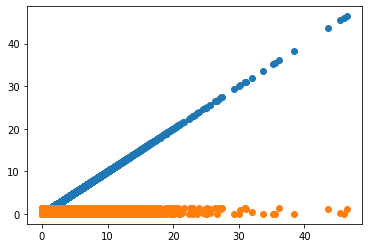

In [34]:
# 测试数据
testInput2 = torch.exp(torch.randn((200, 200), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE]).view(-1, 1))
targetY2 = testInput2
estimateY2 = nn1.predict(testInput2)
plt.scatter(testInput2.cpu().numpy().flatten(), targetY2.cpu().numpy().flatten())
plt.scatter(testInput2.cpu().numpy().flatten(), estimateY2.cpu().numpy().flatten())
plt.show()